# Permutation Feature Importance

In this assignment, you'll evaluate feature importance using permutation.

First, you will estimate feature importance using a random forests. 

Next, you'll estimate feature importance using any of the libraries that we covered in this section.

Finally, you will use permutation feature importance to select features recursively.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from feature_engine.selection import SelectByShuffling
from eli5.sklearn import PermutationImportance


## Load data

In [2]:
variables = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
             'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',  '1stFlrSF',
             '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
             'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
             'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
             'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
             'MoSold', 'YrSold', 'SalePrice']

In [3]:
# load dataset

data = pd.read_csv('../../houseprice.csv', usecols=variables)

data.shape

(2919, 34)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotArea        2919 non-null   int64  
 2   OverallQual    2919 non-null   int64  
 3   OverallCond    2919 non-null   int64  
 4   YearBuilt      2919 non-null   int64  
 5   YearRemodAdd   2919 non-null   int64  
 6   BsmtFinSF1     2918 non-null   float64
 7   BsmtFinSF2     2918 non-null   float64
 8   BsmtUnfSF      2918 non-null   float64
 9   TotalBsmtSF    2918 non-null   float64
 10  1stFlrSF       2919 non-null   int64  
 11  2ndFlrSF       2919 non-null   int64  
 12  LowQualFinSF   2919 non-null   int64  
 13  GrLivArea      2919 non-null   int64  
 14  BsmtFullBath   2917 non-null   float64
 15  BsmtHalfBath   2917 non-null   float64
 16  FullBath       2919 non-null   int64  
 17  HalfBath       2919 non-null   int64  
 18  BedroomA

In [5]:
cols = ["BsmtFullBath", "BsmtHalfBath"]

for c in cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")
    data[c] = data[c].fillna(data[c].median()).round().astype(int)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotArea        2919 non-null   int64  
 2   OverallQual    2919 non-null   int64  
 3   OverallCond    2919 non-null   int64  
 4   YearBuilt      2919 non-null   int64  
 5   YearRemodAdd   2919 non-null   int64  
 6   BsmtFinSF1     2918 non-null   float64
 7   BsmtFinSF2     2918 non-null   float64
 8   BsmtUnfSF      2918 non-null   float64
 9   TotalBsmtSF    2918 non-null   float64
 10  1stFlrSF       2919 non-null   int64  
 11  2ndFlrSF       2919 non-null   int64  
 12  LowQualFinSF   2919 non-null   int64  
 13  GrLivArea      2919 non-null   int64  
 14  BsmtFullBath   2919 non-null   int32  
 15  BsmtHalfBath   2919 non-null   int32  
 16  FullBath       2919 non-null   int64  
 17  HalfBath       2919 non-null   int64  
 18  BedroomA

In [7]:
# Drop rows where SalePrice is NaN
data = data.dropna(subset=["SalePrice"])

# (optional) reset index after dropping
data = data.reset_index(drop=True)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotArea        1460 non-null   int64  
 2   OverallQual    1460 non-null   int64  
 3   OverallCond    1460 non-null   int64  
 4   YearBuilt      1460 non-null   int64  
 5   YearRemodAdd   1460 non-null   int64  
 6   BsmtFinSF1     1460 non-null   float64
 7   BsmtFinSF2     1460 non-null   float64
 8   BsmtUnfSF      1460 non-null   float64
 9   TotalBsmtSF    1460 non-null   float64
 10  1stFlrSF       1460 non-null   int64  
 11  2ndFlrSF       1460 non-null   int64  
 12  LowQualFinSF   1460 non-null   int64  
 13  GrLivArea      1460 non-null   int64  
 14  BsmtFullBath   1460 non-null   int32  
 15  BsmtHalfBath   1460 non-null   int32  
 16  FullBath       1460 non-null   int64  
 17  HalfBath       1460 non-null   int64  
 18  BedroomA

In [9]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 33), (438, 33))

## Random Forests

In [10]:
# Train Random Forests

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    random_state=2909,)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

In [11]:
# R2 in train set

rf.score(X_train, y_train)

0.8078308037529935

In [12]:
# R2 in test set

rf.score(X_test, y_test)

0.780510833461595

## Tree derived feature importance

Extract and plot the importance derived from the random forests. Which features are more important?

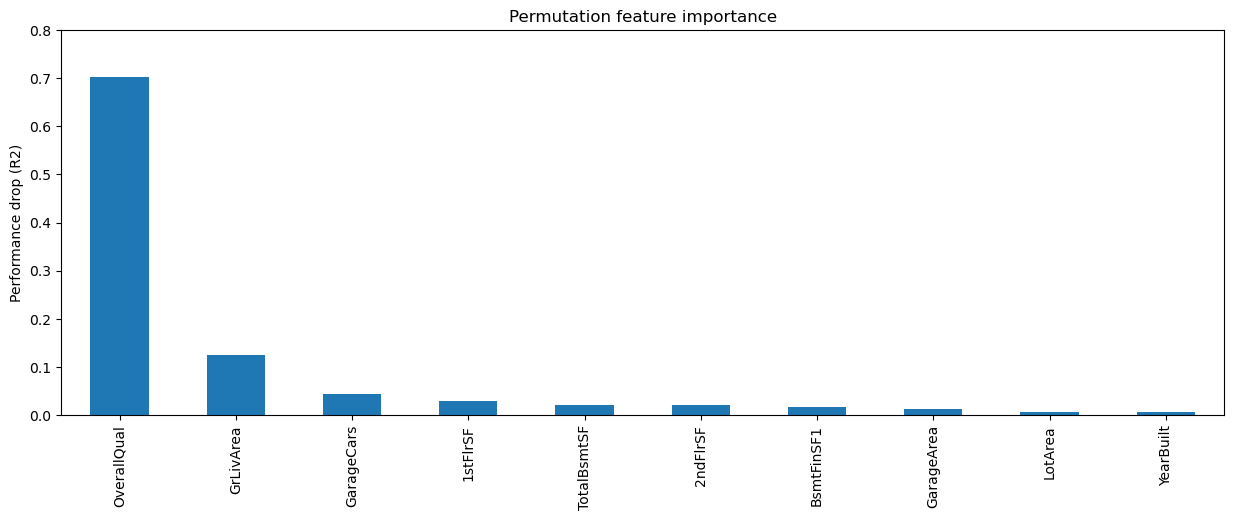

In [13]:
# 10 most important features

pd.Series(
    rf.feature_importances_,
    index=rf.feature_names_in_,
).sort_values(
    ascending=False
).head(10).plot.bar(figsize=(15, 5))

plt.title("Permutation feature importance")
plt.ylabel("Performance drop (R2)")
plt.ylim(0, 0.8)
plt.show()

## Permutation Feature Importance

Calculate and plot feature importance by permutation. Use any Python library you like.

In [14]:
sel = SelectByShuffling(
    variables=None,  # automatically examine all numerical variables
    estimator=rf,  # the ML model
    scoring='r2',  # the metric to evaluate
    threshold=0.01,  # the maximum performance drop allowed to select the feature
    cv=3,  # cross-validation
    random_state=1  # seed
)

sel.fit(X_train, y_train)

,estimator,RandomForestR...om_state=2909)
,scoring,'r2'
,cv,3
,threshold,0.01
,variables,None
,random_state,1
,confirm_variables,False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2


## Permutation with RFE

We will now use permutation importance to select features, but we will do it recursively.

Tasks:

- implement recursive feature elimination using permutation (you'll need to combine Eli5 and sklearn)
- plot the importance of the selected features
- draw some conclusion